In [4]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from findiff import FinDiff
import pysptools.spectro as spectro
from IPython.display import display 

scalers = [
#     'wo_norm',
    'minmax',
    'standard'
]

satellites = [
    'landsat_simulated',
    'landsat_simulated_indices',
    'sentinel2_simulated',
    'sentinel2_simulated_indices',
#     'desis_simulated',
#     'sentinel2_soil',
#     'sentinel2_soil_indices',
#     'sentinel2_all',
#     'sentinel2_all_indices',
#     'vis_nir'
]

satellites_with_indices = [
    i for i in satellites if i.split('_')[-1] == 'indices'
]

soil_properties = [
    'pH',
    'OM',
    'Ca',
    'Mg',
    'K',
    'Na'
]

indices_ = [
    'NDVI', 'GNDVI', 'EVI', 'AVI', 'SAVI',
    'NDMI', 'MSI', 'GCI', 'NDSI', 'BSI',
    'NDWI', 'ARVI', 'SIPI', 'NBR', 'NDGI'
]

scalers_funct = {
#     'wo_norm': ['-1' for _ in range(5)],
    'minmax': [MinMaxScaler() for _ in range(5 + len(indices_))],
    'standard': [StandardScaler() for _ in range(5 + len(indices_)) ]
}

thresholds_path = '../data/processed_raw/soil_cane_vis_NIRS/soil_properties_thresholds.csv'

In [5]:
def check_path(path):
    files = path.split('/')
    tmp_path = ''
    
    for file in files:
        tmp_path += f"{file}/"
        if not os.path.exists(tmp_path):
            os.mkdir(tmp_path)
#         else:
#             print(f'File: **{file}** exists')

            
def is_float(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

In [6]:

for satellite in satellites:
    print(f"satellite: {satellite}")
    
    # Loading data
    #####################################################################

    soil_nir_data = pd.read_csv(
        f'../data/interim_raw/{satellite}/satellite_{satellite}.csv',
        sep = ";"
    )
    display(soil_nir_data.head())
    thresholds = pd.read_csv(thresholds_path, sep = ";")

    # Filterin data
    #####################################################################
    
    if satellite in satellites_with_indices:
        non_spectral_columns = list(set(soil_properties)| set(indices_))
    else:
        non_spectral_columns = soil_properties

    for scaler in scalers:     
#         print(f"scaler: {scaler}")
        
        df_soil_properties = soil_nir_data[soil_properties].copy()    
        spectral_data = soil_nir_data.drop(non_spectral_columns, axis=1).copy()
        spectral_data_array = np.asarray(spectral_data)
        
        temp_cols = [i.split('_')[-1] for i in spectral_data.columns]
        spectral_data_cols = list(map(float, temp_cols))

        # Transforming data
        #####################################################################
        
        d1_dx_array = (
            np.diff(spectral_data_array[0]) / np.diff(spectral_data_cols)
        ).reshape(1,-1)

        d2_dx_array = (
            np.diff(d1_dx_array[0]) / np.diff(spectral_data_cols[:-1])
        ).reshape(1,-1)

        fft_array = np.fft.fft(spectral_data_array[0]).reshape(1,-1)

        continuum_removal_array = np.array(
            spectro.convex_hull_removal(
                1.5 - spectral_data_array[0],
                spectral_data_cols
            )[0]
        ).reshape(1,-1)

        for spectrum in spectral_data_array[1:]:
            d1x_ = (
                np.diff(spectrum) / np.diff(spectral_data_cols)
            ).reshape(1,-1)
            
            d2x_ = (
                np.diff(d1x_[0]) / np.diff(spectral_data_cols[:-1])
            ).reshape(1,-1)
            
            fft_ = np.fft.fft(spectrum).reshape(1,-1)
            
            continuum_removal_ = np.array(
                spectro.convex_hull_removal(
                    1.5 - spectrum, spectral_data_cols
                )[0]
            ).reshape(1,-1)

            d1_dx_array = np.append(d1_dx_array, d1x_, axis=0)
            d2_dx_array = np.append(d2_dx_array, d2x_, axis=0)
            fft_array = np.append(fft_array, fft_, axis=0)
            continuum_removal_array = np.append(
                continuum_removal_array, continuum_removal_, axis=0
            )

        # Normalizing data
        #####################################################################

        spectrum_scaler = scalers_funct[scaler][0]
        d1x_scaler = scalers_funct[scaler][1]
        d2_scaler = scalers_funct[scaler][2]
        continuum_removal_scaler = scalers_funct[scaler][3]

        if spectrum_scaler != '-1':
            spectrum_scaler.fit(spectral_data_array)
            d1x_scaler.fit(d1_dx_array)
            d2_scaler.fit(d2_dx_array)
            continuum_removal_scaler.fit(continuum_removal_array)

            spectral_data_array_scale = spectrum_scaler.transform(spectral_data_array)
            d1_dx_array_scale = d1x_scaler.transform(d1_dx_array)
            d2_dx_array_scale = d2_scaler.transform(d2_dx_array)
            continuum_removal_scale = continuum_removal_scaler.transform(continuum_removal_array)
            fft_array_scale = (np.absolute(fft_array)/int(fft_array.shape[1]))
        else:
            spectral_data_array_scale = spectral_data_array.copy()
            d1_dx_array_scale = d1_dx_array.copy()
            d2_dx_array_scale = d2_dx_array.copy()
            continuum_removal_scale = continuum_removal_array.copy()
            fft_array_scale = fft_array.astype(float).copy()

#         Joining all transform data
#         ####################################################################

        all_data_columns = []
        transformations = ['scE_', 'd1_', 'd2_', 'fft_', 'cr_']

        for trans_ in transformations:
            for col in spectral_data_cols:
                if ((trans_ == 'd1_' and col in [spectral_data_cols[-1]]) or
                    (trans_ == 'd2_' and col in spectral_data_cols[-2:])):
                    continue
                all_data_columns.append(f'{trans_}{col}')

        all_data = np.concatenate(
            (
                spectral_data_array_scale, 
                d1_dx_array_scale, 
                d2_dx_array_scale, 
                fft_array_scale,
                continuum_removal_scale
            ), axis=1
        )

        all_data_final = pd.DataFrame(
            data=all_data,
            columns=all_data_columns
        )

        # Creating CSV file with all the features of the used_propeties
        #####################################################################

        properties_scaler = scalers_funct[scaler][4]
        
        # Choose properties
        soil_properties_ = [
            'pH',
            'OM',
            'Ca',
            'Mg',
            'K',
            'Na'
        ]
        
        for property_ in soil_properties_:
            
            temp_all_data = all_data_final.copy()
            comp_values = list(df_soil_properties[property_])

            comp_labels = []
            comp_thresholds = thresholds[thresholds['compuesto'] == property_]

            for comp_vi in comp_values:   
                for index, row in comp_thresholds.iterrows():
                    if (comp_vi > row['lim_inf']) and (comp_vi <= row['lim_sup']):
                        comp_labels.append(row['etiqueta'])

            comp_values_ = np.array(comp_values).reshape(-1,1)
            
            if properties_scaler != '-1':
                properties_scaler.fit(comp_values_)
                comp_values_scale = properties_scaler.transform(comp_values_)
            else:
                comp_values_scale = comp_values_.copy()

            comp_values_ = comp_values_.flatten()
            comp_values_scale = comp_values_scale.flatten()

            ids = list(range(0, len(comp_values_)))

            for temp_id, col_ in enumerate(indices_):
                if col_ in soil_nir_data.columns:
                    temp_scaler = scalers_funct[scaler][5 + temp_id]
                    temp_index_data = np.array(soil_nir_data[col_]).reshape(-1,1)
                    temp_index_data = temp_scaler.fit_transform(temp_index_data).flatten()
                    temp_all_data.insert(0, col_, temp_index_data)

            temp_all_data.insert (0, f'sc_{property_}', comp_values_scale)
            temp_all_data.insert (0, property_, comp_values_)
            temp_all_data.insert (0, f'Et_{property_}', comp_labels)
            temp_all_data.insert (0, 'ID', ids)

            display(temp_all_data.head())
            
            check_path(f'../data/models/input/{satellite}/{scaler}/')
        
            temp_all_data.to_csv(
                f'../data/models/input/{satellite}/{scaler}/' +
                f"All_{scaler}_d1d2_fft_feature_{property_}_.csv",
                sep = ';',
                decimal = '.',
                index=False
            )


satellite: landsat_simulated


,pH,OM,Ca,Mg,K,Na,B1_440.0,B2_480.0,B3_560.0,B4_650.0,B5_865.0,B6_1610.0,B7_2200.0,B8_590.0,B9_1370.0
0,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.845176,0.808018,0.583812,0.468327,0.346967,0.233701,0.312968,0.562034,0.242112
1,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,1.084242,1.068213,0.916832,0.789667,0.579897,0.345258,0.427153,0.885312,0.366688
2,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,0.864876,0.833472,0.665972,0.557266,0.404134,0.251068,0.299480,0.641684,0.269407
3,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,1.048510,1.021950,0.862561,0.749102,0.593996,0.433071,0.472209,0.836179,0.449921
4,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,0.911629,0.881942,0.688968,0.553039,0.387019,0.247129,0.293715,0.657246,0.259705


,ID,Et_pH,pH,sc_pH,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Extremadamente_Acido,4.70,0.154897,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Extremadamente_Acido,5.00,0.223235,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Extremadamente_Acido,5.07,0.239180,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Extremadamente_Acido,4.55,0.120729,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Extremadamente_Acido,4.44,0.095672,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_OM,OM,sc_OM,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Medio,3.011138,0.136317,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Alto,12.271341,0.622491,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Alto,5.326189,0.257860,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Alto,7.198116,0.356139,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Medio,4.643188,0.222002,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Ca,Ca,sc_Ca,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.481978,0.003325,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,1.287727,0.011955,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Medio,3.592768,0.036642,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,1.198907,0.011004,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,2.353349,0.023368,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Mg,Mg,sc_Mg,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.213796,0.035033,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,0.418722,0.069638,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Bajo,0.533857,0.089080,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,0.452394,0.075324,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,0.526435,0.087827,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_K,K,sc_K,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.171674,0.077257,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Alto,0.421729,0.203249,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Medio,0.213425,0.098293,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Alto,0.428312,0.206566,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Medio,0.336426,0.160269,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Na,Na,sc_Na,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.146597,0.100413,0.173310,0.156782,0.028093,0.005302,0.000000,0.057283,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,0.201236,0.139339,0.553316,0.539105,0.504685,0.489903,0.426739,0.286474,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Bajo,0.176261,0.121546,0.204625,0.194184,0.145674,0.139427,0.104734,0.092963,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,0.220661,0.153178,0.496518,0.471129,0.427017,0.428728,0.452569,0.466884,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,0.173677,0.119706,0.278941,0.265404,0.178584,0.133054,0.073378,0.084870,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_pH,pH,sc_pH,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Extremadamente_Acido,4.70,-0.896840,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Extremadamente_Acido,5.00,-0.641419,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Extremadamente_Acido,5.07,-0.581821,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Extremadamente_Acido,4.55,-1.024550,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Extremadamente_Acido,4.44,-1.118204,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_OM,OM,sc_OM,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Medio,3.011138,-1.253046,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Alto,12.271341,1.913537,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Alto,5.326189,-0.461400,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Alto,7.198116,0.178717,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Medio,4.643188,-0.694956,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Ca,Ca,sc_Ca,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.481978,-0.793530,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,1.287727,-0.734827,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Medio,3.592768,-0.566895,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,1.198907,-0.741298,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,2.353349,-0.657192,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Mg,Mg,sc_Mg,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.213796,-1.053806,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,0.418722,-0.749111,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Bajo,0.533857,-0.577922,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,0.452394,-0.699046,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,0.526435,-0.588957,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_K,K,sc_K,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.171674,-0.670042,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Alto,0.421729,0.521701,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Medio,0.213425,-0.471061,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Alto,0.428312,0.553076,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Medio,0.336426,0.115157,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Na,Na,sc_Na,scE_440.0,scE_480.0,scE_560.0,scE_650.0,scE_865.0,scE_1610.0,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.146597,-0.490865,-2.286973,-2.327452,-2.530209,-2.464816,-2.187012,-1.522605,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,0.201236,-0.241117,0.399369,0.382558,0.323584,0.214297,0.186907,0.300638,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Bajo,0.176261,-0.355275,-2.065605,-2.062335,-1.826142,-1.723304,-1.604385,-1.238766,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,0.220661,-0.152328,-0.002146,-0.099279,-0.141483,-0.123909,0.330597,1.735826,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,0.173677,-0.367085,-1.540249,-1.557512,-1.629083,-1.758541,-1.778816,-1.303142,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


satellite: landsat_simulated_indices


,pH,OM,Ca,Mg,K,Na,B1_440.0,B2_480.0,B3_560.0,B4_650.0,...,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,NDGI,ARVI,SIPI
0,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.845176,0.808018,0.583812,0.468327,...,0.195061,0.673554,-0.405688,0.051518,0.211801,0.254459,0.428264,0.109762,0.104382,3.799027
1,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,1.084242,1.068213,0.916832,0.789667,...,0.253622,0.595378,-0.367499,0.151675,1.330859,0.225114,0.452879,0.074518,0.021310,2.327862
2,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,0.864876,0.833472,0.665972,0.557266,...,0.233617,0.621248,-0.393166,0.148739,0.514881,0.244684,0.452439,0.088868,0.052325,2.803721
3,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,1.048510,1.021950,0.862561,0.749102,...,0.156684,0.729081,-0.311358,0.114224,1.431190,0.184384,0.331491,0.070399,0.037809,2.759114
4,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,0.911629,0.881942,0.688968,0.553039,...,0.220596,0.638544,-0.438262,0.137063,0.483262,0.280625,0.472001,0.109442,0.068581,2.981096


,ID,Et_pH,pH,sc_pH,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Extremadamente_Acido,4.70,0.154897,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Extremadamente_Acido,5.00,0.223235,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Extremadamente_Acido,5.07,0.239180,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Extremadamente_Acido,4.55,0.120729,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Extremadamente_Acido,4.44,0.095672,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_OM,OM,sc_OM,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Medio,3.011138,0.136317,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Alto,12.271341,0.622491,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Alto,5.326189,0.257860,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Alto,7.198116,0.356139,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Medio,4.643188,0.222002,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Ca,Ca,sc_Ca,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.481978,0.003325,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,1.287727,0.011955,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Medio,3.592768,0.036642,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,1.198907,0.011004,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,2.353349,0.023368,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Mg,Mg,sc_Mg,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.213796,0.035033,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,0.418722,0.069638,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Bajo,0.533857,0.089080,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,0.452394,0.075324,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,0.526435,0.087827,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_K,K,sc_K,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.171674,0.077257,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Alto,0.421729,0.203249,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Medio,0.213425,0.098293,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Alto,0.428312,0.206566,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Medio,0.336426,0.160269,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_Na,Na,sc_Na,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.146597,0.100413,0.822012,0.180622,0.593505,0.865262,0.726385,0.031681,...,0.118853,0.0,0.864223,1.000000,1.0,0.0,0.0,0.0,0.942443,0.0
1,1,Bajo,0.201236,0.139339,0.464432,0.471358,0.190782,0.311332,0.603075,0.502760,...,0.149288,0.0,0.814152,0.991877,1.0,0.0,0.0,0.0,0.937592,0.0
2,2,Bajo,0.176261,0.121546,0.610021,0.462837,0.321046,0.518141,0.685308,0.159266,...,0.123496,0.0,0.914264,1.000000,1.0,0.0,0.0,0.0,0.964685,0.0
3,3,Bajo,0.220661,0.153178,0.422643,0.362647,0.308834,0.421350,0.431924,0.544996,...,0.125486,0.0,0.859537,1.000000,1.0,0.0,0.0,0.0,0.945806,0.0
4,4,Bajo,0.173677,0.119706,0.818769,0.428944,0.369601,0.626536,0.836333,0.145955,...,0.135921,0.0,0.864595,1.000000,1.0,0.0,0.0,0.0,0.952104,0.0


,ID,Et_pH,pH,sc_pH,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Extremadamente_Acido,4.70,-0.896840,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Extremadamente_Acido,5.00,-0.641419,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Extremadamente_Acido,5.07,-0.581821,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Extremadamente_Acido,4.55,-1.024550,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Extremadamente_Acido,4.44,-1.118204,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_OM,OM,sc_OM,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Medio,3.011138,-1.253046,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Alto,12.271341,1.913537,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Alto,5.326189,-0.461400,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Alto,7.198116,0.178717,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Medio,4.643188,-0.694956,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Ca,Ca,sc_Ca,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.481978,-0.793530,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,1.287727,-0.734827,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Medio,3.592768,-0.566895,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,1.198907,-0.741298,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,2.353349,-0.657192,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Mg,Mg,sc_Mg,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.213796,-1.053806,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,0.418722,-0.749111,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Bajo,0.533857,-0.577922,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,0.452394,-0.699046,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,0.526435,-0.588957,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_K,K,sc_K,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.171674,-0.670042,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Alto,0.421729,0.521701,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Medio,0.213425,-0.471061,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Alto,0.428312,0.553076,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Medio,0.336426,0.115157,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


,ID,Et_Na,Na,sc_Na,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,fft_1370.0,cr_440.0,cr_480.0,cr_560.0,cr_650.0,cr_865.0,cr_1610.0,cr_2200.0,cr_590.0,cr_1370.0
0,0,Bajo,0.146597,-0.490865,2.257902,-2.150994,3.192627,3.184167,0.847198,-2.502817,...,0.118853,0.0,0.556621,0.442094,0.289887,0.0,0.0,0.0,0.367147,0.0
1,1,Bajo,0.201236,-0.241117,0.160655,-0.464436,-0.147586,-0.092899,0.054995,0.289507,...,0.149288,0.0,-0.042575,0.370571,0.289887,0.0,0.0,0.0,0.320194,0.0
2,2,Bajo,0.176261,-0.355275,1.014552,-0.513869,0.932830,1.130587,0.583298,-1.746557,...,0.123496,0.0,1.155452,0.442094,0.289887,0.0,0.0,0.0,0.582469,0.0
3,3,Bajo,0.220661,-0.152328,-0.084440,-1.095071,0.831550,0.557968,-1.044564,0.539857,...,0.125486,0.0,0.500544,0.442094,0.289887,0.0,0.0,0.0,0.399711,0.0
4,4,Bajo,0.173677,-0.367085,2.238879,-0.710478,1.335551,1.771853,1.553562,-1.825455,...,0.135921,0.0,0.561064,0.442094,0.289887,0.0,0.0,0.0,0.460674,0.0


satellite: sentinel2_simulated


,pH,OM,Ca,Mg,K,Na,B1_443.9,B2_496.6,B3_560.0,B4_664.5,B5_703.9,B6_740.2,B7_782.5,B8_835.1,B8A_864.8,B9_945.0,B11_1613.7,B12_2202.4
0,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.844222,0.742902,0.594799,0.455716,0.420031,0.391398,0.369552,0.357787,0.346151,0.329373,0.234380,0.312788
1,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,1.084577,1.024587,0.924741,0.771936,0.721580,0.679715,0.639911,0.605115,0.577240,0.531714,0.346386,0.432581
2,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,0.863350,0.785385,0.674149,0.543348,0.503266,0.469970,0.440225,0.420608,0.402748,0.377293,0.251452,0.300813
3,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,1.047152,0.976819,0.870760,0.734812,0.693970,0.661369,0.633083,0.610929,0.592339,0.563219,0.433349,0.475339
4,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,0.910143,0.827656,0.699175,0.537009,0.491197,0.453930,0.423285,0.403942,0.385648,0.361293,0.247524,0.295509


,ID,Et_pH,pH,sc_pH,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Extremadamente_Acido,4.70,0.154897,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Extremadamente_Acido,5.00,0.223235,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Extremadamente_Acido,5.07,0.239180,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Extremadamente_Acido,4.55,0.120729,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Extremadamente_Acido,4.44,0.095672,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_OM,OM,sc_OM,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Medio,3.011138,0.136317,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Alto,12.271341,0.622491,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Alto,5.326189,0.257860,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Alto,7.198116,0.356139,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Medio,4.643188,0.222002,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Ca,Ca,sc_Ca,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.481978,0.003325,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,1.287727,0.011955,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Medio,3.592768,0.036642,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,1.198907,0.011004,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,2.353349,0.023368,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Mg,Mg,sc_Mg,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.213796,0.035033,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,0.418722,0.069638,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Bajo,0.533857,0.089080,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,0.452394,0.075324,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,0.526435,0.087827,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_K,K,sc_K,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.171674,0.077257,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Alto,0.421729,0.203249,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Medio,0.213425,0.098293,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Alto,0.428312,0.206566,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Medio,0.336426,0.160269,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Na,Na,sc_Na,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.146597,0.100413,0.173656,0.118184,0.034820,0.005604,0.007189,0.010753,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,0.201236,0.139339,0.552009,0.529403,0.506220,0.485452,0.474619,0.470370,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Bajo,0.176261,0.121546,0.203767,0.180203,0.148190,0.138580,0.136211,0.136008,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,0.220661,0.153178,0.493097,0.459669,0.429096,0.429117,0.431821,0.441123,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,0.173677,0.119706,0.277426,0.241913,0.183946,0.128962,0.117503,0.110438,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_pH,pH,sc_pH,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Extremadamente_Acido,4.70,-0.896840,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Extremadamente_Acido,5.00,-0.641419,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Extremadamente_Acido,5.07,-0.581821,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Extremadamente_Acido,4.55,-1.024550,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Extremadamente_Acido,4.44,-1.118204,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_OM,OM,sc_OM,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Medio,3.011138,-1.253046,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Alto,12.271341,1.913537,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Alto,5.326189,-0.461400,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Alto,7.198116,0.178717,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Medio,4.643188,-0.694956,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Ca,Ca,sc_Ca,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.481978,-0.793530,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,1.287727,-0.734827,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Medio,3.592768,-0.566895,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,1.198907,-0.741298,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,2.353349,-0.657192,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Mg,Mg,sc_Mg,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.213796,-1.053806,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,0.418722,-0.749111,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Bajo,0.533857,-0.577922,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,0.452394,-0.699046,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,0.526435,-0.588957,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_K,K,sc_K,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.171674,-0.670042,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Alto,0.421729,0.521701,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Medio,0.213425,-0.471061,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Alto,0.428312,0.553076,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Medio,0.336426,0.115157,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Na,Na,sc_Na,scE_443.9,scE_496.6,scE_560.0,scE_664.5,scE_703.9,scE_740.2,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.146597,-0.490865,-2.279362,-2.420716,-2.527828,-2.447302,-2.382115,-2.314652,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,0.201236,-0.241117,0.401170,0.363785,0.325376,0.199383,0.174262,0.183351,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Bajo,0.176261,-0.355275,-2.066037,-2.000763,-1.841642,-1.713846,-1.676495,-1.633895,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,0.220661,-0.152328,-0.016203,-0.108404,-0.141425,-0.111338,-0.059801,0.024393,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,0.173677,-0.367085,-1.544179,-1.582904,-1.625226,-1.766900,-1.778806,-1.772867,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


satellite: sentinel2_simulated_indices


,pH,OM,Ca,Mg,K,Na,B1_443.9,B2_496.6,B3_560.0,B4_664.5,...,NDMI,MSI,GCI,NBR,BSI,NDWI,NDSI,NDGI,ARVI,SIPI
0,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,0.844222,0.742902,0.594799,0.455716,...,0.208399,0.655083,-0.446246,0.067104,0.195807,0.248809,0.434670,-0.248809,0.094058,3.932576
1,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,1.084577,1.024587,0.924741,0.771936,...,0.271917,0.572429,-0.425013,0.166267,1.290748,0.208925,0.454994,-0.208925,0.027045,2.514506
2,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,0.863350,0.785385,0.674149,0.543348,...,0.251698,0.597830,-0.440342,0.166054,0.483439,0.231596,0.456673,-0.231596,0.052034,2.971954
3,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,1.047152,0.976819,0.870760,0.734812,...,0.170051,0.709327,-0.353187,0.124822,1.396722,0.175361,0.335410,-0.175361,0.038636,2.953531
4,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,0.910143,0.827656,0.699175,0.537009,...,0.240103,0.612770,-0.483259,0.155027,0.446282,0.267635,0.477081,-0.267635,0.068346,3.184220


,ID,Et_pH,pH,sc_pH,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Extremadamente_Acido,4.70,0.154897,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Extremadamente_Acido,5.00,0.223235,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Extremadamente_Acido,5.07,0.239180,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Extremadamente_Acido,4.55,0.120729,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Extremadamente_Acido,4.44,0.095672,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_OM,OM,sc_OM,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Medio,3.011138,0.136317,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Alto,12.271341,0.622491,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Alto,5.326189,0.257860,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Alto,7.198116,0.356139,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Medio,4.643188,0.222002,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Ca,Ca,sc_Ca,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.481978,0.003325,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,1.287727,0.011955,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Medio,3.592768,0.036642,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,1.198907,0.011004,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,2.353349,0.023368,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Mg,Mg,sc_Mg,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.213796,0.035033,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,0.418722,0.069638,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Bajo,0.533857,0.089080,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,0.452394,0.075324,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,0.526435,0.087827,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_K,K,sc_K,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.171674,0.077257,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Alto,0.421729,0.203249,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Medio,0.213425,0.098293,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Alto,0.428312,0.206566,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Medio,0.336426,0.160269,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_Na,Na,sc_Na,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.146597,0.100413,0.217422,0.174455,0.630405,0.893191,0.782578,0.030520,...,1.000000,1.0,1.0,1.0,1.0,0.980153,1.0,1.0,0.0,0.0
1,1,Bajo,0.201236,0.139339,0.398538,0.464254,0.222287,0.329658,0.601462,0.492368,...,0.960467,1.0,1.0,1.0,1.0,0.813567,1.0,1.0,0.0,0.0
2,2,Bajo,0.176261,0.121546,0.295591,0.463634,0.353940,0.539795,0.704409,0.151843,...,1.000000,1.0,1.0,1.0,1.0,0.913956,1.0,1.0,0.0,0.0
3,3,Bajo,0.220661,0.153178,0.550956,0.343134,0.348638,0.427131,0.449044,0.537068,...,1.000000,1.0,1.0,1.0,1.0,0.894733,1.0,1.0,0.0,0.0
4,4,Bajo,0.173677,0.119706,0.131933,0.431405,0.415030,0.676973,0.868067,0.136171,...,1.000000,1.0,1.0,1.0,1.0,0.898685,1.0,1.0,0.0,0.0


,ID,Et_pH,pH,sc_pH,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Extremadamente_Acido,4.70,-0.896840,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Extremadamente_Acido,5.00,-0.641419,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Extremadamente_Acido,5.07,-0.581821,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Extremadamente_Acido,4.55,-1.024550,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Extremadamente_Acido,4.44,-1.118204,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_OM,OM,sc_OM,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Medio,3.011138,-1.253046,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Alto,12.271341,1.913537,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Alto,5.326189,-0.461400,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Alto,7.198116,0.178717,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Medio,4.643188,-0.694956,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Ca,Ca,sc_Ca,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.481978,-0.793530,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,1.287727,-0.734827,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Medio,3.592768,-0.566895,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,1.198907,-0.741298,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,2.353349,-0.657192,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Mg,Mg,sc_Mg,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.213796,-1.053806,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,0.418722,-0.749111,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Bajo,0.533857,-0.577922,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,0.452394,-0.699046,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,0.526435,-0.588957,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_K,K,sc_K,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.171674,-0.670042,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Alto,0.421729,0.521701,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Medio,0.213425,-0.471061,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Alto,0.428312,0.553076,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Medio,0.336426,0.115157,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


,ID,Et_Na,Na,sc_Na,NDGI,NBR,SIPI,ARVI,NDWI,BSI,...,cr_560.0,cr_664.5,cr_703.9,cr_740.2,cr_782.5,cr_835.1,cr_864.8,cr_945.0,cr_1613.7,cr_2202.4
0,0,Bajo,0.146597,-0.490865,-1.173090,-2.172663,3.177412,3.165690,1.173090,-2.445746,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.854772,0.077333,0.074315,0.0,0.0
1,1,Bajo,0.201236,-0.241117,-0.041855,-0.499070,-0.068382,-0.031478,0.041855,0.278118,...,0.221942,0.430676,0.410689,0.21054,0.105707,0.067737,0.077333,0.074315,0.0,0.0
2,2,Bajo,0.176261,-0.355275,-0.684855,-0.502651,0.978662,1.160722,0.684855,-1.730211,...,0.538562,0.430676,0.410689,0.21054,0.105707,1.144646,0.077333,0.074315,0.0,0.0
3,3,Bajo,0.220661,-0.152328,0.910126,-1.198541,0.936495,0.521528,-0.910126,0.541747,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.938430,0.077333,0.074315,0.0,0.0
4,4,Bajo,0.173677,-0.367085,-1.707044,-0.688772,1.464515,1.938990,1.707044,-1.822646,...,0.538562,0.430676,0.410689,0.21054,0.105707,0.980823,0.077333,0.074315,0.0,0.0


### Pruebas derivada numérica

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

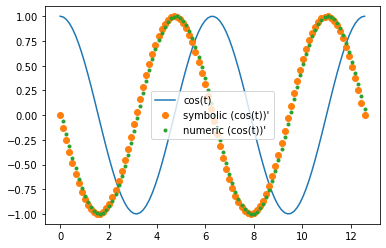

In [9]:
t = np.linspace(0, 4*np.pi, 100)
y = np.cos(t) # Función original
kdy = -np.sin(t) # Derivada simbólica
dy = np.diff(y)/np.diff(t) # Derivada numérica

plt.plot(t, y, '-', label='cos(t)')
plt.plot(t, kdy, 'o', label='symbolic (cos(t))\'')
plt.plot(t[1:], dy, '.', label='numeric (cos(t))\' ')
 
plt.legend()
plt.show()

In [10]:
path_soil_data = os.path.abspath(f'../data/nirs/soil_cane_vis-NIR.csv')
soil_nir_data = pd.read_csv(path_soil_data, sep = ";")

In [11]:
print(soil_nir_data.shape)
soil_nir_data[soil_nir_data.columns].head()

(653, 257)


,Sand,Clay,Silt,pH_3Cat,pH,OM,Ca,Mg,K,Na,...,2414.5,2423,2431.5,2440,2448.5,2457,2465.5,2474,2482.5,2491
0,18.4,41.2,40.4,4.70,4.70,3.011138,0.481978,0.213796,0.171674,0.146597,...,0.371383,0.378890,0.386586,0.392239,0.395681,0.398774,0.402525,0.406814,0.411534,0.414343
1,68.4,15.2,16.4,5.00,5.00,12.271341,1.287727,0.418722,0.421729,0.201236,...,0.502976,0.510954,0.519375,0.526996,0.533605,0.540453,0.547456,0.554312,0.560825,0.565450
2,28.4,37.2,34.4,5.07,5.07,5.326189,3.592768,0.533857,0.213425,0.176261,...,0.348180,0.354749,0.361053,0.365611,0.368472,0.371119,0.373985,0.377056,0.380232,0.382145
3,32.4,35.2,32.4,4.55,4.55,7.198116,1.198907,0.452394,0.428312,0.220661,...,0.523816,0.531462,0.538671,0.543519,0.547046,0.550635,0.554689,0.558928,0.563029,0.565520
4,20.4,35.2,44.4,4.44,4.44,4.643188,2.353349,0.526435,0.336426,0.173677,...,0.342146,0.348621,0.354735,0.359123,0.362023,0.364714,0.367813,0.370938,0.374218,0.376289


In [12]:
diff_step = 8.5
print(diff_step)
d1_dx = FinDiff(0, diff_step, 1, acc = 10)
d2_dx = FinDiff(0, diff_step, 2, acc = 10)

8.5


In [14]:
n = 50
t = np.arange(8.5, 8.5*(n+1), 8.5)
y = soil_nir_data.iloc[:n, 10]
print(len(t), ' ', len(y))

50   50


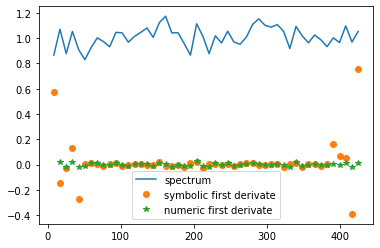

In [15]:
dy1 = d1_dx(y)
dy1_ = (np.diff(y)/np.diff(t))

plt.plot(t, y, '-', label='spectrum')
plt.plot(t, dy1, 'o', label='symbolic first derivate')
plt.plot(t[1:], dy1_, '*', label='numeric first derivate')
 
plt.legend()
plt.show()

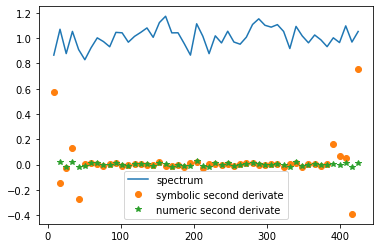

In [16]:
dy2 = d2_dx(dy1)
dx_2_ = (np.diff(dy1_)/np.diff(t[1:]))

plt.plot(t, y, '-', label='spectrum')
plt.plot(t, dy1, 'o', label='symbolic second derivate')
plt.plot(t[1:], dy1_, '*', label='numeric second derivate')
 
plt.legend()
plt.show()